<a href="https://colab.research.google.com/github/cmatheusIA/dados_02/blob/main/great_tech_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Autor : Carlos Matheus R. Martins

Engenharia de Software

Universidade Federal do Ceará Campus Russas


# Imports, Libs, metodos, configs

In [102]:
import pandas as pd
import numpy as np
import seaborn as  sns
import plotly.express as px
import matplotlib.pyplot as plt
from math import sqrt
import plotly.graph_objects as go
import plotly.express as px
import datetime as dt
import plotly.colors as plc
from pathlib import Path
from scipy.stats import randint as sp_randint
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score,RandomizedSearchCV
from collections import Counter
from sklearn.metrics import f1_score, make_scorer,recall_score,precision_score,accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
import tensorflow as tf
import warnings

In [2]:
path = "https://raw.githubusercontent.com/cmatheusIA/dados_02/main/Use_Of_Force.csv"

In [3]:
mapa_beat = {
    "E1":"E",
    "E2":"E",
    "E3":"E",
    "K1":"K",
    "K2":"K",
    "K3":"K",
    "N1":"N",
    "N2":"N",
    "N3":"N",
    'C1':"C",
    'C2':"C",
    'C3':"C",
    'W1':"W",
    'W2':"W",
    'W3':"W",
    'U1':'U',
    'U2':'U',
    'U3':'U',
    'J1':'J',
    'J2':'J',
    'J3':'J',
    'M1':'M',
    'M2':'M',
    'M3':'M',
    'F1':'F',
    'F2':'F',
    'F3':'F',
    'B1':'B',
    'B2':'B',
    'B3':'B',
    'G1':'G',
    'G2':'G',
    'G3':'G',
    'Q1':'Q',
    'Q2':'Q',
    'Q3':'Q',
    'R1':"R",
    'R2':"R",
    'R3':"R",
    'S1':'S',
    'S2':'S',
    'S3':'S',
    'D1':'D',
    'D2':'D',
    'D3':'D',
    'L1':'L',
    'L2':'L',
    'L3':'L',
    'O1':'O',
    'O2':'O',
    'O3':'O'
}

In [4]:
warnings.simplefilter("ignore")

In [5]:
###### configurations for image quality#######
plt.rcParams["figure.figsize"] = [16, 10]   ##
#plt.rcParams['figure.dpi'] = 100          ## 
plt.rc('font', size=10)                    ## 
plt.rc('axes', titlesize=14)               ## 
plt.rc('axes', labelsize=14)               ##
plt.rc('xtick', labelsize=10)              ##
plt.rc('ytick', labelsize=10)              ##
plt.rc('legend', fontsize=10)              ##
plt.rc('figure', titlesize=12)             ## 
#############################################

In [6]:
def run_models_compare(X,y,modelos=[]):
  recall = []
  precision = []
  nome_modelos=[]
  acc=[]

  print("-"*50)  
  for model in modelos:
      print(model.__class__.__name__)
      nome_modelos.append(model.__class__.__name__)
      for name,score in [("recall",recall_score),("precision",precision_score),("accuracy",_)]:
          if name is 'accuracy':
            cvs = cross_val_score(model, X,y, scoring=name, cv=3)
          else:
            cvs = cross_val_score(model, X,y, scoring=make_scorer(score,average='weighted'), cv=3)
          mean = cvs.mean()
          std = cvs.std()
          print(name + " : "+ str(round(mean,3)) + " std : "+ str(round(std,3)))
          print("Intervalo :  [{:.2f}% ~ {:.2f}%]".format((mean - 2*std)*100, (mean + 2*std)*100))
          print()
          if name == "recall":
              recall.append(round(mean,3))
          elif name == "precision":
              precision.append(round(mean,3))
          else:
              acc.append(round(mean,3))
      print()
  df_models_train = pd.DataFrame(data=zip(recall,precision,acc), index=nome_modelos, columns=['recall','precision','acc'])
  return df_models_train

In [112]:
def metricas(y_true,y_pred,model_name,target_names):
  print(f"model {model_name}")
  print(f"Acuracia = {accuracy_score(y_true,y_pred) *100} %")
  print(f"Precisao = {precision_score(y_true,y_pred, average='weighted') *100} %")
  print(f"Recall = {recall_score(y_true,y_pred,average='weighted')* 100} %")
  print("="*50)
  print(classification_report(y_true, y_pred, target_names=target_names))

In [8]:
def model(X_train, num_class):
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_class, activation='softmax')
])
  return model

In [9]:
def load_data(path):
  return pd.read_csv(path)

In [10]:
def Smote(X,y,num_class):
  smote = SMOTE(sampling_strategy='auto', k_neighbors=num_class, random_state=42)
  X_train_res, y_train_res = smote.fit_resample(X, y)

  return X_train_res, y_train_res


In [11]:
def plot_pie(data,name):
  fig = go.Figure(data=[go.Pie(labels=data.index, values=data.values, hole=.3)])

  # definindo o título do gráfico
  fig.update_layout(
      title={
          'text': f"Distribuição de {name}",
          'y':0.9,
          'x':0.5,
          'xanchor': 'center',
          'yanchor': 'top'})

  # retorno
  return fig


In [27]:
def plot_bar(data,x,y,color,titulo):
  fig = px.bar(data, x=x, y=y, color=color)

  # definindo o título do gráfico
  fig.update_layout(
      title={
          'text': titulo,
          'y':0.99,
          'x':0.5,
          'xanchor': 'center',
          'yanchor': 'top',
          })

  # mostrando o gráfico
  fig.show()

In [40]:
def plot_line_TS(data,titulo,x_label,y_label):
  plt.plot(data.index, data.values)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(titulo)
  plt.show()

# Analise descritiva

In [63]:
# carregando os dados
df = load_data(path)
df.head()

,ID,Incident_Num,Incident_Type,Occured_date_time,Precinct,Sector,Beat,Officer_ID,Subject_ID,Subject_Race,Subject_Gender
0,2014UOF-0001-1377-203,251,Level 1 - Use of Force,06/07/2014 12:09:00 AM,East,CHARLIE,C2,1594,203,Black or African American,Male
1,2014UOF-0002-1098-166,218,Level 1 - Use of Force,05/30/2014 02:06:00 PM,East,GEORGE,G1,1673,166,White,Male
2,2014UOF-0003-1031-125,178,Level 1 - Use of Force,05/23/2014 05:24:00 PM,West,KING,K3,1690,125,Asian,Female
3,2014UOF-0004-767-126,179,Level 1 - Use of Force,05/26/2014 12:10:00 AM,East,EDWARD,E2,953,126,Black or African American,Male
4,2014UOF-0005-1473-172,223,Level 1 - Use of Force,06/01/2014 04:03:00 PM,South,ROBERT,R1,1145,172,Black or African American,Male


Inspecionando dados

Aqui vamos visualizar os 5 primeiros dados do dataframe, informações sobre o dataframe tipo de variaveis dados Nulos, memoria usada para carregar o dataframe e dados únicos 

In [64]:
display(df.head())
print("-"*50)
display(df.info())
print("-"*50)
display(df.nunique())

,ID,Incident_Num,Incident_Type,Occured_date_time,Precinct,Sector,Beat,Officer_ID,Subject_ID,Subject_Race,Subject_Gender
0,2014UOF-0001-1377-203,251,Level 1 - Use of Force,06/07/2014 12:09:00 AM,East,CHARLIE,C2,1594,203,Black or African American,Male
1,2014UOF-0002-1098-166,218,Level 1 - Use of Force,05/30/2014 02:06:00 PM,East,GEORGE,G1,1673,166,White,Male
2,2014UOF-0003-1031-125,178,Level 1 - Use of Force,05/23/2014 05:24:00 PM,West,KING,K3,1690,125,Asian,Female
3,2014UOF-0004-767-126,179,Level 1 - Use of Force,05/26/2014 12:10:00 AM,East,EDWARD,E2,953,126,Black or African American,Male
4,2014UOF-0005-1473-172,223,Level 1 - Use of Force,06/01/2014 04:03:00 PM,South,ROBERT,R1,1145,172,Black or African American,Male


--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14264 entries, 0 to 14263
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 14264 non-null  object
 1   Incident_Num       14264 non-null  int64 
 2   Incident_Type      14264 non-null  object
 3   Occured_date_time  14264 non-null  object
 4   Precinct           14264 non-null  object
 5   Sector             13313 non-null  object
 6   Beat               14264 non-null  object
 7   Officer_ID         14264 non-null  int64 
 8   Subject_ID         14264 non-null  int64 
 9   Subject_Race       14264 non-null  object
 10  Subject_Gender     14264 non-null  object
dtypes: int64(3), object(8)
memory usage: 1.2+ MB


None

--------------------------------------------------


ID                   14264
Incident_Num         13488
Incident_Type            4
Occured_date_time    10699
Precinct                 9
Sector                  17
Beat                    55
Officer_ID            1323
Subject_ID            7503
Subject_Race             8
Subject_Gender           9
dtype: int64

In [66]:
df.describe()

,Incident_Num,Officer_ID,Subject_ID,hours
count,14264.000000,14264.000000,14264.000000,14264.000000
mean,28139.467330,1930.426248,12386.183188,13.456254
std,22232.312987,1146.934687,8320.522755,7.203518
min,178.000000,7.000000,4.000000,0.000000
25%,8612.000000,1252.000000,4777.000000,8.000000
50%,19011.500000,1736.000000,12093.500000,15.000000
75%,51943.250000,2154.000000,18995.000000,20.000000
max,68122.000000,6046.000000,29302.000000,23.000000


In [69]:
df.describe(include='O')

,ID,Incident_Type,Precinct,Sector,Beat,Subject_Race,Subject_Gender,time,day_name
count,14264,14264,14264,13313,14264,14264,14264,14264,14264
unique,14264,4,9,17,55,8,9,1382,7
top,2014UOF-0001-1377-203,Level 1 - Use of Force,West,EDWARD,E2,White,Male,16:00:00,Saturday
freq,1,10173,4061,1738,1117,5733,10658,137,2281


In [191]:
# transformando coluna Occured_date_time
df.Occured_date_time = pd.to_datetime(df.Occured_date_time)
df["time"] = df.Occured_date_time.dt.time
df["hours"] = df.Occured_date_time.dt.hour
df["data"] = pd.to_datetime(df.Occured_date_time.dt.date)
df["ano"] = df.Occured_date_time.dt.year
df["day_name"] = df.Occured_date_time.dt.day_name()

In [192]:
df.head()

,ID,Incident_Num,Incident_Type,Occured_date_time,Precinct,Sector,Beat,Officer_ID,Subject_ID,Subject_Race,Subject_Gender,time,hours,data,day_name,ano
0,2014UOF-0001-1377-203,251,Level 1 - Use of Force,2014-06-07 00:09:00,East,CHARLIE,C2,1594,203,Black or African American,Male,00:09:00,0,2014-06-07,Saturday,2014
1,2014UOF-0002-1098-166,218,Level 1 - Use of Force,2014-05-30 14:06:00,East,GEORGE,G1,1673,166,White,Male,14:06:00,14,2014-05-30,Friday,2014
2,2014UOF-0003-1031-125,178,Level 1 - Use of Force,2014-05-23 17:24:00,West,KING,K3,1690,125,Asian,Female,17:24:00,17,2014-05-23,Friday,2014
3,2014UOF-0004-767-126,179,Level 1 - Use of Force,2014-05-26 00:10:00,East,EDWARD,E2,953,126,Black or African American,Male,00:10:00,0,2014-05-26,Monday,2014
4,2014UOF-0005-1473-172,223,Level 1 - Use of Force,2014-06-01 16:03:00,South,ROBERT,R1,1145,172,Black or African American,Male,16:03:00,16,2014-06-01,Sunday,2014


### Analise Univariada

checando percentual de algumas colunas

In [16]:
df.Subject_Gender.replace("m","Other",inplace=True)
df.Subject_Gender.replace("-","Other",inplace=True)

In [17]:
genero = df.Subject_Gender.value_counts(normalize=True)

In [18]:
fig = plot_pie(genero,"Genero")
fig.show()

In [19]:
raca = df.Subject_Race.value_counts(normalize=True)

In [20]:
figure = plot_pie(raca,"Etnias")
figure.show()

In [21]:
sector = df.Sector.value_counts(normalize=True)
figure = plot_pie(sector,"Setores")
figure.show()

### Análise Multivariada

In [22]:
incident_race = df.groupby("Incident_Type",as_index=False)["Subject_Race"].value_counts()
incident_race.head()

,Incident_Type,Subject_Race,count
0,Level 1 - Use of Force,White,4058
1,Level 1 - Use of Force,Black or African American,3588
2,Level 1 - Use of Force,Not Specified,1355
3,Level 1 - Use of Force,Hispanic or Latino,514
4,Level 1 - Use of Force,Asian,375


In [28]:
plot_bar(incident_race,"Subject_Race","count","Incident_Type","Contagem da força policial por Raça")


Gráfico deixa claro  que o LvL 1 é a força principal usada em todas as categorias de raça existentes no dataframe

In [43]:
incident_hour = df.groupby(df['hours'])['Incident_Num'].count()
incident_hour

hours
0      792
1      685
2      562
3      319
4      314
5      268
6      245
7      226
8      233
9      241
10     333
11     375
12     591
13     741
14     777
15     822
16     902
17     750
18     684
19     690
20    1056
21     920
22     913
23     825
Name: Incident_Num, dtype: int64

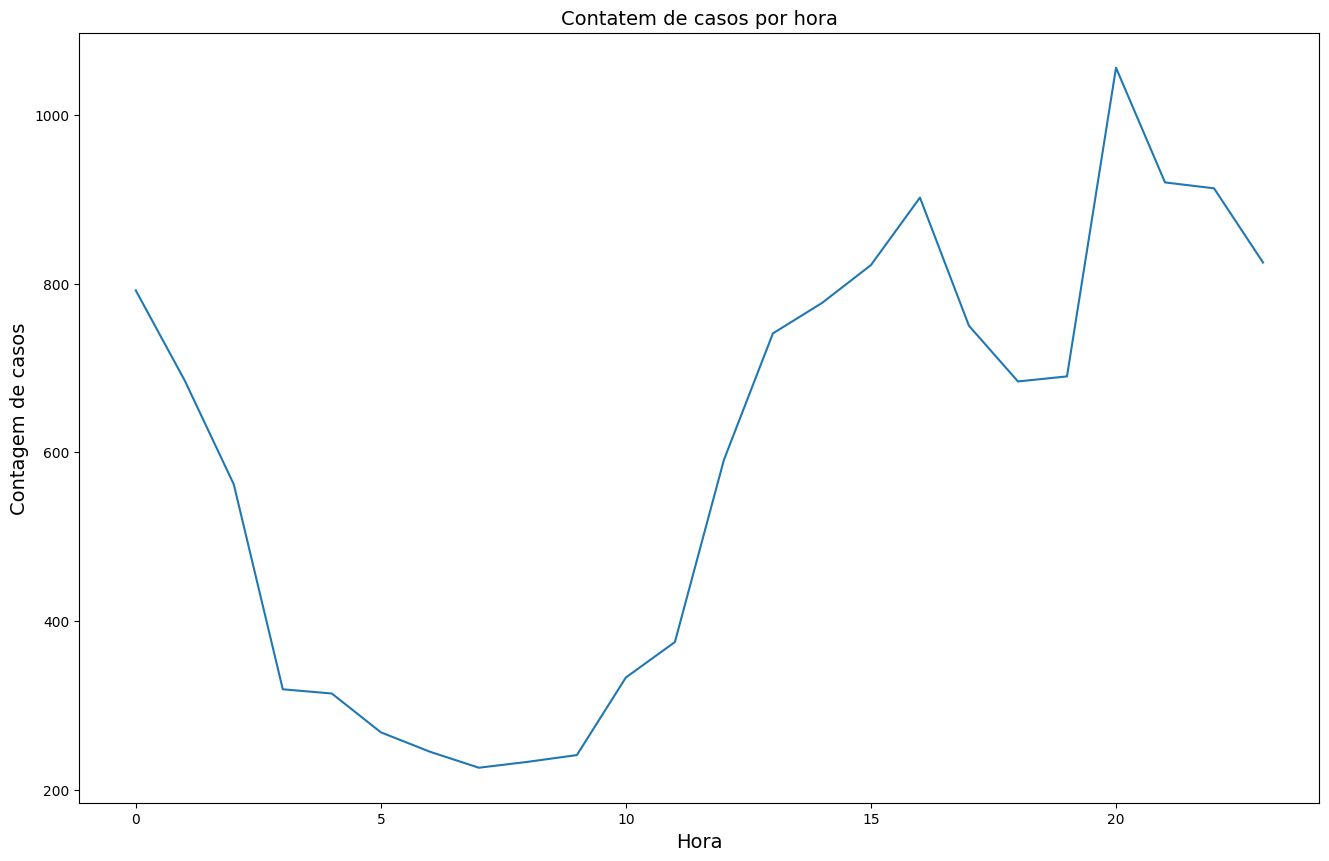

In [45]:
plot_line_TS(incident_hour,"Contatem de casos por hora","Hora","Contagem de casos")

In [193]:
incident_ano = df.groupby(df['ano'])['Incident_Num'].count()
incident_ano

ano
2014    1671
2015    1993
2016    1527
2017    1582
2018    2182
2019    1318
2020    1977
2021     981
2022      82
Name: Incident_Num, dtype: int64

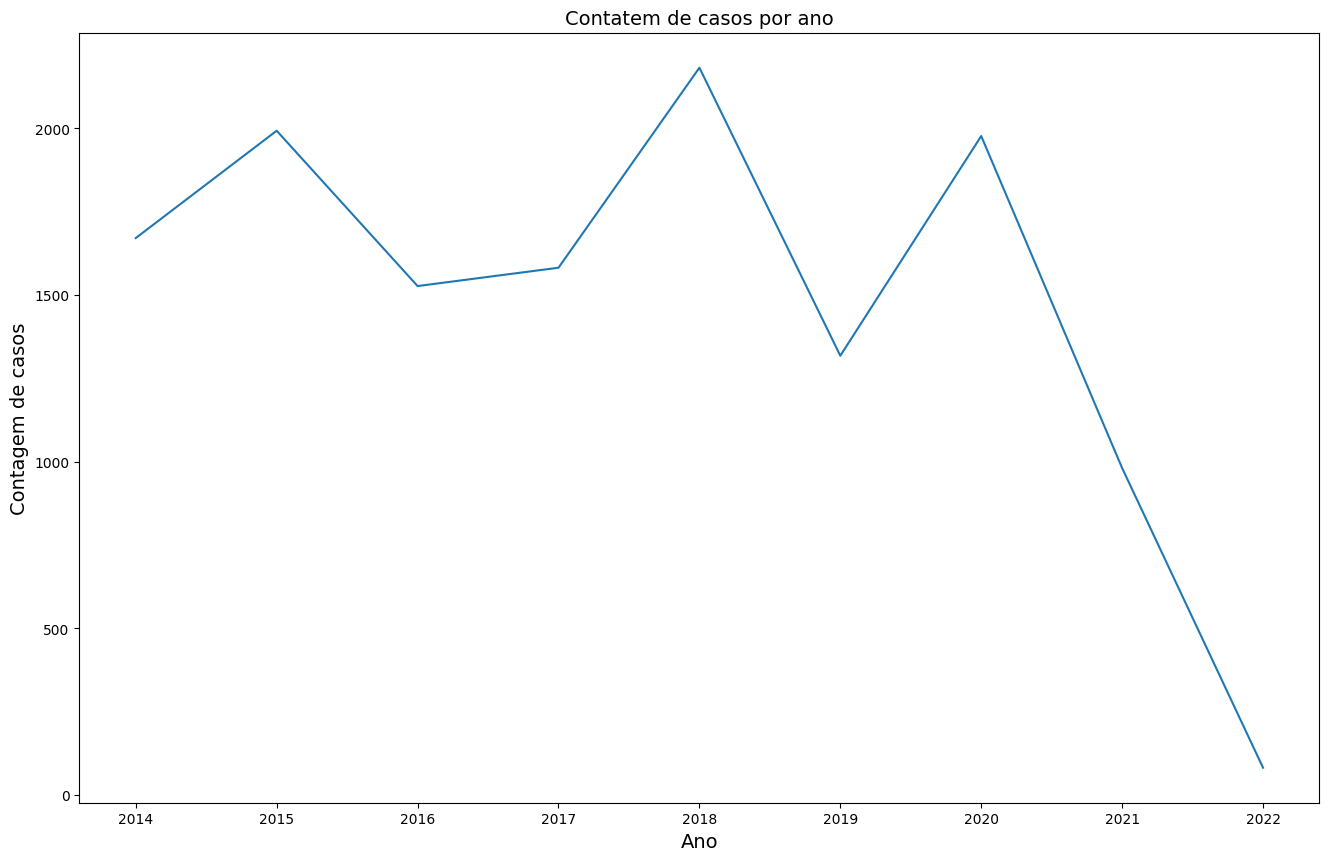

In [194]:
plot_line_TS(incident_ano,"Contatem de casos por ano","Ano","Contagem de casos")

Entre 5 e 10 horas é o horário em que é registrado o menor número de casos, enquanto a partir das 20 horas ocorre um aumento no número de casos. Já em relação aos anos, nota-se que o ano de 2018 apresentou o maior número de casos, enquanto nos anos de 2020 a 2022, houve uma redução nos registros de casos.

In [50]:
df.Beat = df.Beat.map(mapa_beat)

In [58]:
df.Beat.unique()

array(['C', 'G', 'K', 'E', 'R', 'S', 'L', 'U', 'D', 'F', 'J', 'N', nan,
       'B', 'O', 'Q', 'W', 'M'], dtype=object)

In [59]:
df.Beat.fillna('Other',inplace=True)

In [61]:
incident_Beat = df.groupby(df['Beat'],as_index=False)['Incident_Num'].count()
incident_Beat

,Beat,Incident_Num
0,B,525
1,C,425
2,D,1049
3,E,2689
4,F,471
5,G,688
6,J,441
7,K,1505
8,L,644
9,M,998


In [62]:
plot_bar(incident_Beat,"Beat","Incident_Num",None,"Numero de incidente por Beat")

As zonas E e K são as zonas que tem mais incidentes por beat

In [ ]:
incident_precinct = df.groupby(df['Incident_Type'],as_index=False)["Precinct"].value_counts()
incident_precinct

In [71]:
plot_bar(incident_precinct,"Precinct","count","Incident_Type","Contagem da força policial por Região")

Podemos identificar que quase não existe operações com força policial lvl 3 em "Southwest","East"

# Modelagem

preprocessamento

In [78]:
df.isna().sum()/df.shape[0]

ID                   0.0
Incident_Num         0.0
Incident_Type        0.0
Occured_date_time    0.0
Precinct             0.0
Sector               0.0
Beat                 0.0
Officer_ID           0.0
Subject_ID           0.0
Subject_Race         0.0
Subject_Gender       0.0
time                 0.0
hours                0.0
data                 0.0
day_name             0.0
dtype: float64

In [77]:
df.dropna(inplace=True)

In [79]:
X = df[['Precinct','Beat', 'Subject_Race', 'Subject_Gender']]
y = df[['Incident_Type']]

Irei agrupar os Generos Transgenero masculino,femino e não binario em um unico grupo devido ao números serem pequenos.

In [80]:
X.Subject_Gender.replace("Transgender Male","Transgender_Male_or_Female",inplace=True)
X.Subject_Gender.replace("Transgender Female","Transgender_Male_or_Female",inplace=True)
X.Subject_Gender.replace("Non-binary","Other",inplace=True)

In [82]:
# Criando encoders
ohe = OneHotEncoder(handle_unknown='ignore')
le = LabelEncoder()

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [84]:
print(f"Shape dos dados de treino X_train->{X_train.shape} , y_train->{y_train.shape}")
print(f"Shape dos dados de treino X_test->{X_test.shape} , y_test->{y_test.shape}")

Shape dos dados de treino X_train->(10650, 4) , y_train->(10650, 1)
Shape dos dados de treino X_test->(2663, 4) , y_test->(2663, 1)


In [85]:
X_train = ohe.fit_transform(X_train[['Precinct', 'Beat', 'Subject_Race', 'Subject_Gender']]).toarray()

In [96]:
X_test = ohe.fit_transform(X_test[['Precinct', 'Beat', 'Subject_Race', 'Subject_Gender']]).toarray()

In [86]:
x_train = pd.DataFrame(X_train, columns=ohe.get_feature_names_out(X.columns))

In [97]:
x_test = pd.DataFrame(X_test, columns=ohe.get_feature_names_out(X.columns))

In [87]:
y_train = le.fit_transform(y_train.Incident_Type)

In [98]:
y_test_ = le.fit_transform(y_test.Incident_Type)

In [88]:
modelos = [LogisticRegression(),DecisionTreeClassifier(),RandomForestClassifier(),AdaBoostClassifier(),GradientBoostingClassifier(),GaussianNB(),SVC()]

In [89]:
df_treino = run_models_compare(x_train,y_train,modelos=modelos)

--------------------------------------------------
LogisticRegression
recall : 0.736 std : 0.004
Intervalo :  [72.75% ~ 74.48%]

precision : 0.704 std : 0.008
Intervalo :  [68.84% ~ 72.03%]

accuracy : 0.736 std : 0.004
Intervalo :  [72.75% ~ 74.48%]


DecisionTreeClassifier
recall : 0.736 std : 0.003
Intervalo :  [73.09% ~ 74.19%]

precision : 0.711 std : 0.008
Intervalo :  [69.61% ~ 72.63%]

accuracy : 0.737 std : 0.003
Intervalo :  [73.05% ~ 74.25%]


RandomForestClassifier
recall : 0.734 std : 0.003
Intervalo :  [72.74% ~ 74.13%]

precision : 0.708 std : 0.01
Intervalo :  [68.88% ~ 72.80%]

accuracy : 0.736 std : 0.003
Intervalo :  [73.09% ~ 74.10%]


AdaBoostClassifier
recall : 0.717 std : 0.007
Intervalo :  [70.39% ~ 73.06%]

precision : 0.698 std : 0.01
Intervalo :  [67.73% ~ 71.80%]

accuracy : 0.717 std : 0.007
Intervalo :  [70.39% ~ 73.06%]


GradientBoostingClassifier
recall : 0.738 std : 0.003
Intervalo :  [73.08% ~ 74.47%]

precision : 0.716 std : 0.008
Intervalo :  [70.01

In [94]:
df_treino.sort_values(by='precision',ascending=False)

,recall,precision,acc
SVC,0.739,0.720,0.739
GradientBoostingClassifier,0.738,0.716,0.738
DecisionTreeClassifier,0.736,0.711,0.737
RandomForestClassifier,0.734,0.708,0.736
LogisticRegression,0.736,0.704,0.736
GaussianNB,0.165,0.703,0.165
AdaBoostClassifier,0.717,0.698,0.717


Aqui vamos pegar SVC e o GradientBoostingClassifier para tuna os parametros e realizar testes

SVC

In [109]:
svc=SVC(probability=True)
svc.fit(x_train,y_train)

SVC(probability=True)

In [113]:
y_pred_prob = svc.predict_proba(x_test)
y_pred = svc.predict(x_test)

Logloss = 0.6338498355597907


In [117]:
target = ['Level 1 - Use of Force', 'Level 2 - Use of Force', 	'Level 3 - Use of Force', 	'Level 3 - OIS']
metricas(y_test_,y_pred, svc.__class__.__name__, target)
print(f"Logloss = {log_loss(y_pred=y_pred_prob,y_true=y_test_)}")

model SVC
Acuracia = 73.4885467517837 %
Precisao = 71.6724621377444 %
Recall = 73.4885467517837 %
                        precision    recall  f1-score   support

Level 1 - Use of Force       0.74      0.97      0.84      1874
Level 2 - Use of Force       0.70      0.19      0.29       750
Level 3 - Use of Force       0.00      0.00      0.00        16
         Level 3 - OIS       0.00      0.00      0.00        23

              accuracy                           0.73      2663
             macro avg       0.36      0.29      0.28      2663
          weighted avg       0.72      0.73      0.67      2663

Logloss = 0.6338498355597907


O modelo teve um desempenho relativamente bom para a classe Level 1 - Use of Force, com uma precisão de 74% e um recall de 97%. Para a classe Level 2 - Use of Force, a precisão foi de 70% e o recall foi de 19%, indicando que o modelo teve mais dificuldade em identificar corretamente as instâncias dessa classe.

As classes Level 3 - Use of Force e Level 3 - OIS tiveram uma precisão e recall de 0%, indicando que o modelo não conseguiu identificar nenhuma instância dessas classes corretamente.

O Log Loss foi calculado como 0.6338, o que indica a qualidade geral das probabilidades previstas pelo modelo. O valor do Log Loss varia de 0 a infinito, e quanto mais próximo de zero, melhor é a qualidade das probabilidades previstas.

GradientBoostingClassifier

In [118]:
gb = GradientBoostingClassifier()
gb.fit(x_train,y_train)

GradientBoostingClassifier()

In [119]:
y_pred_prob = gb.predict_proba(x_test)
y_pred = gb.predict(x_test)

In [120]:
target = ['Level 1 - Use of Force', 'Level 2 - Use of Force', 	'Level 3 - Use of Force', 	'Level 3 - OIS']
metricas(y_test_,y_pred, gb.__class__.__name__, target)
print(f"Logloss = {log_loss(y_pred=y_pred_prob,y_true=y_test_)}")

model GradientBoostingClassifier
Acuracia = 73.60120165227187 %
Precisao = 71.72602340448037 %
Recall = 73.60120165227187 %
                        precision    recall  f1-score   support

Level 1 - Use of Force       0.74      0.97      0.84      1874
Level 2 - Use of Force       0.70      0.20      0.31       750
Level 3 - Use of Force       0.00      0.00      0.00        16
         Level 3 - OIS       0.00      0.00      0.00        23

              accuracy                           0.74      2663
             macro avg       0.36      0.29      0.29      2663
          weighted avg       0.72      0.74      0.68      2663

Logloss = 0.6093190590216134


O modelo teve um desempenho relativamente bom para a classe Level 1 - Use of Force, com uma precisão de 74% e um recall de 97%. Para a classe Level 2 - Use of Force, a precisão foi de 70% e o recall foi de 20%, indicando que o modelo teve mais dificuldade em identificar corretamente as instâncias dessa classe.

As classes Level 3 - Use of Force e Level 3 - OIS tiveram uma precisão e recall de 0%, indicando que o modelo não conseguiu identificar nenhuma instância dessas classes corretamente.

O Log Loss foi calculado como 0.6093, o que indica a qualidade geral das probabilidades previstas pelo modelo. O valor do Log Loss varia de 0 a infinito, e quanto mais próximo de zero, melhor é a qualidade das probabilidades previstas. O valor do Log Loss do modelo Gradient Boosting Classifier foi menor que o do modelo SVC, o que indica uma melhor calibração das probabilidades previstas pelo modelo.

In [136]:
from scipy.stats import uniform

In [183]:
params = {'C':[0.01,1,10] ,
          'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
          'gamma': ['scale', 'auto'] + [0.01,1,10]}



# Criando o objeto de busca
search = RandomizedSearchCV(svc, params, cv=3, n_iter=20, n_jobs=-1, verbose=1, random_state=42)

# Realizando a busca pelos melhores hiperparâmetros
search.fit(x_train, y_train)

# Extraindo os melhores hiperparâmetros
print("Melhores hiperparâmetros: ", search.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Melhores hiperparâmetros:  {'kernel': 'poly', 'gamma': 1, 'C': 0.01}


In [187]:
# Treinando os modelos com os melhores hiperparâmetros
svc_best = SVC(**search.best_params_)
svc_best.set_params(probability=True)
svc_best.fit(X_train, y_train)

SVC(C=0.01, gamma=1, kernel='poly', probability=True)

In [188]:
y_pred_prob = svc_best.predict_proba(x_test)
y_pred = svc_best.predict(x_test)

In [189]:
target = ['Level 1 - Use of Force', 'Level 2 - Use of Force', 	'Level 3 - Use of Force', 	'Level 3 - OIS']
metricas(y_test_,y_pred, svc_best.__class__.__name__, target)
print(f"Logloss = {log_loss(y_pred=y_pred_prob,y_true=y_test_)}")

model SVC
Acuracia = 73.4885467517837 %
Precisao = 71.6724621377444 %
Recall = 73.4885467517837 %
                        precision    recall  f1-score   support

Level 1 - Use of Force       0.74      0.97      0.84      1874
Level 2 - Use of Force       0.70      0.19      0.29       750
Level 3 - Use of Force       0.00      0.00      0.00        16
         Level 3 - OIS       0.00      0.00      0.00        23

              accuracy                           0.73      2663
             macro avg       0.36      0.29      0.28      2663
          weighted avg       0.72      0.73      0.67      2663

Logloss = 0.634188199550686


Uma maneira de melhorar é balanceando os dados, vamos tentar essa abbordagem abaixo

Com Smote

In [121]:
x_train_res , y_train_res = Smote(x_train,y_train,4)

In [123]:
print(f"Shape dos dados de treino x_train_res->{x_train_res.shape} , y_train->{y_train_res.shape}")


Shape dos dados de treino x_train_res->(30240, 70) , y_train->(30240,)


In [124]:
df_treino = run_models_compare(x_train_res , y_train_res,modelos=modelos)

--------------------------------------------------
LogisticRegression
recall : 0.568 std : 0.007
Intervalo :  [55.28% ~ 58.23%]

precision : 0.566 std : 0.006
Intervalo :  [55.45% ~ 57.78%]

accuracy : 0.568 std : 0.007
Intervalo :  [55.28% ~ 58.23%]


DecisionTreeClassifier
recall : 0.782 std : 0.008
Intervalo :  [76.56% ~ 79.75%]

precision : 0.774 std : 0.008
Intervalo :  [75.72% ~ 79.03%]

accuracy : 0.782 std : 0.008
Intervalo :  [76.54% ~ 79.81%]


RandomForestClassifier
recall : 0.785 std : 0.009
Intervalo :  [76.61% ~ 80.32%]

precision : 0.777 std : 0.009
Intervalo :  [75.86% ~ 79.59%]

accuracy : 0.785 std : 0.009
Intervalo :  [76.62% ~ 80.36%]


AdaBoostClassifier
recall : 0.485 std : 0.006
Intervalo :  [47.31% ~ 49.73%]

precision : 0.502 std : 0.006
Intervalo :  [49.01% ~ 51.48%]

accuracy : 0.485 std : 0.006
Intervalo :  [47.31% ~ 49.73%]


GradientBoostingClassifier
recall : 0.746 std : 0.01
Intervalo :  [72.55% ~ 76.55%]

precision : 0.741 std : 0.01
Intervalo :  [72.16

In [125]:
df_treino.sort_values(by='precision',ascending=False)

,recall,precision,acc
RandomForestClassifier,0.785,0.777,0.785
DecisionTreeClassifier,0.782,0.774,0.782
GradientBoostingClassifier,0.746,0.741,0.746
SVC,0.745,0.735,0.745
LogisticRegression,0.568,0.566,0.568
GaussianNB,0.439,0.562,0.439
AdaBoostClassifier,0.485,0.502,0.485


Aqui já tivemos resultados diferentes onde os 2 primeiros modelos foram RandomForest e DecisionTree, agora vamos chegar como nos passos anteriores

In [126]:
rf = RandomForestClassifier()
dt = DecisionTreeClassifier()

RandomForest

In [131]:
rf.fit(x_train,y_train)
y_pred_prob = rf.predict_proba(x_test)
y_pred = rf.predict(x_test)

In [132]:
target = ['Level 1 - Use of Force', 'Level 2 - Use of Force', 	'Level 3 - Use of Force', 	'Level 3 - OIS']
metricas(y_test_,y_pred, rf.__class__.__name__, target)
print(f"Logloss = {log_loss(y_pred=y_pred_prob,y_true=y_test_)}")

model RandomForestClassifier
Acuracia = 73.37589185129552 %
Precisao = 70.58384859334255 %
Recall = 73.37589185129552 %
                        precision    recall  f1-score   support

Level 1 - Use of Force       0.74      0.95      0.83      1874
Level 2 - Use of Force       0.65      0.23      0.34       750
Level 3 - Use of Force       0.00      0.00      0.00        16
         Level 3 - OIS       0.00      0.00      0.00        23

              accuracy                           0.73      2663
             macro avg       0.35      0.29      0.29      2663
          weighted avg       0.71      0.73      0.68      2663

Logloss = 0.9410954314236443


 A acurácia do modelo foi de 73,30%, o que significa que ele classificou corretamente 73,30% dos exemplos.

A precisão do modelo foi de 70,40%, o que significa que de todas as classificações positivas que o modelo fez, 70,40% estavam corretas. O recall do modelo foi de 73,30%, o que significa que ele identificou corretamente 73,30% das instâncias positivas no conjunto de teste.

O f1-score é uma média harmônica entre precisão e recall, e o valor para cada classe é uma média harmônica entre precisão e recall para essa classe. O modelo obteve um f1-score de 0,83 para a classe "Level 1 - Use of Force", 0,34 para a classe "Level 2 - Use of Force", e 0 para as outras duas classes.

A métrica de Logloss foi de 0,9765, o que indica o quão bem o modelo é capaz de prever a probabilidade correta para cada classe. Um valor baixo de logloss indica que o modelo é capaz de prever com alta probabilidade a classe correta para cada instância, enquanto um valor alto de logloss indica que o modelo tem dificuldade em prever com alta probabilidade a classe correta.

No geral, o modelo parece ter um desempenho razoável na classe "Level 1 - Use of Force", mas seu desempenho é bastante ruim para as outras classes, especialmente "Level 3 - Use of Force" e "Level 3 - OIS". É possível que o modelo precise de ajustes para melhorar seu desempenho nessas classes.

**DecisionTree**

In [134]:
dt.fit(x_train,y_train)
y_pred_prob = dt.predict_proba(x_test)
y_pred = dt.predict(x_test)

In [135]:
target = ['Level 1 - Use of Force', 'Level 2 - Use of Force', 	'Level 3 - Use of Force', 	'Level 3 - OIS']
metricas(y_test_,y_pred, dt.__class__.__name__, target)
print(f"Logloss = {log_loss(y_pred=y_pred_prob,y_true=y_test_)}")

model DecisionTreeClassifier
Acuracia = 73.33834021779947 %
Precisao = 70.57929132627746 %
Recall = 73.33834021779947 %
                        precision    recall  f1-score   support

Level 1 - Use of Force       0.74      0.95      0.83      1874
Level 2 - Use of Force       0.65      0.22      0.33       750
Level 3 - Use of Force       0.00      0.00      0.00        16
         Level 3 - OIS       0.00      0.00      0.00        23

              accuracy                           0.73      2663
             macro avg       0.35      0.29      0.29      2663
          weighted avg       0.71      0.73      0.68      2663

Logloss = 1.3120139125322614


Apesar da Acuracia boa, nossos modelos não estão sendo precisos com as categorias lvl 3 , algo que é muito ruim

Tunando os parametros

In [142]:
# Definindo os hiperparâmetros a serem ajustados
parametros_rfc = {'n_estimators': [100, 500, 1000, 2000],
                  'max_depth': [10, 50, 100, None],
                  'max_features': ['auto', 'sqrt'],
                  'min_samples_split': [2, 5, 10],
                  'min_samples_leaf': [1, 2, 4],
                  'class_weight':['balanced','balanced_subsample'],
                  'bootstrap': [True, False]
                  }
                  
parametros_dtc = {'criterion': ['gini', 'entropy'],
                  'max_depth': [10, 50, 100, None],
                  'max_features': ['auto', 'sqrt'],
                  'min_samples_split': [2, 5, 10],
                  'class_weight':['balanced'],
                  'min_samples_leaf': [1, 2, 4]
                  }

In [144]:
rfc_random = RandomizedSearchCV(estimator=rf, param_distributions=parametros_rfc, n_iter=20, cv=3, verbose=2, random_state=42, n_jobs=-1)
rfc_random.fit(X_train, y_train)



Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 50, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 500, 1000, 2000]},
                   random_state=42, verbose=2)

In [145]:
dtc_random = RandomizedSearchCV(estimator=dt, param_distributions=parametros_dtc, n_iter=20, cv=3, verbose=2, random_state=42, n_jobs=-1)
dtc_random.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 50, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10]},
                   random_state=42, verbose=2)

In [146]:
print("Melhores parâmetros para Random Forest:", rfc_random.best_params_)
print("Melhores parâmetros para Decision Tree:", dtc_random.best_params_)

Melhores parâmetros para Random Forest: {'n_estimators': 2000, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 100, 'bootstrap': True}
Melhores parâmetros para Decision Tree: {'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 50, 'criterion': 'gini'}


In [147]:
# Treinando os modelos com os melhores hiperparâmetros
rfc_best = RandomForestClassifier(**rfc_random.best_params_)
rfc_best.fit(X_train, y_train)

dtc_best = DecisionTreeClassifier(**dtc_random.best_params_)
dtc_best.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=50, max_features='auto', min_samples_split=5)

In [148]:
y_pred_prob = dtc_best.predict_proba(x_test)
y_pred = dtc_best.predict(x_test)

In [150]:
target = ['Level 1 - Use of Force', 'Level 2 - Use of Force', 	'Level 3 - Use of Force', 	'Level 3 - OIS']
metricas(y_test_,y_pred, dtc_best.__class__.__name__, target)
print(f"Logloss = {log_loss(y_pred=y_pred_prob,y_true=y_test_)}")

model DecisionTreeClassifier
Acuracia = 73.41344348479159 %
Precisao = 70.77115031348978 %
Recall = 73.41344348479159 %
                        precision    recall  f1-score   support

Level 1 - Use of Force       0.74      0.95      0.84      1874
Level 2 - Use of Force       0.66      0.22      0.33       750
Level 3 - Use of Force       0.00      0.00      0.00        16
         Level 3 - OIS       0.00      0.00      0.00        23

              accuracy                           0.73      2663
             macro avg       0.35      0.29      0.29      2663
          weighted avg       0.71      0.73      0.68      2663

Logloss = 1.2361583314705202


Random Forest

In [151]:
y_pred_prob = rfc_best.predict_proba(x_test)
y_pred = rfc_best.predict(x_test)
target = ['Level 1 - Use of Force', 'Level 2 - Use of Force', 	'Level 3 - Use of Force', 	'Level 3 - OIS']
metricas(y_test_,y_pred, rfc_best.__class__.__name__, target)
print(f"Logloss = {log_loss(y_pred=y_pred_prob,y_true=y_test_)}")

model RandomForestClassifier
Acuracia = 73.26323695080737 %
Precisao = 70.58172635597221 %
Recall = 73.26323695080737 %
                        precision    recall  f1-score   support

Level 1 - Use of Force       0.74      0.96      0.83      1874
Level 2 - Use of Force       0.66      0.21      0.32       750
Level 3 - Use of Force       0.00      0.00      0.00        16
         Level 3 - OIS       0.00      0.00      0.00        23

              accuracy                           0.73      2663
             macro avg       0.35      0.29      0.29      2663
          weighted avg       0.71      0.73      0.68      2663

Logloss = 0.6162726512331244


In [169]:
df

,ID,Incident_Num,Incident_Type,Occured_date_time,Precinct,Sector,Beat,Officer_ID,Subject_ID,Subject_Race,Subject_Gender,time,hours,data,day_name
0,2014UOF-0001-1377-203,251,Level 1 - Use of Force,2014-06-07 00:09:00,East,CHARLIE,C2,1594,203,Black or African American,Male,00:09:00,0,2014-06-07,Saturday
1,2014UOF-0002-1098-166,218,Level 1 - Use of Force,2014-05-30 14:06:00,East,GEORGE,G1,1673,166,White,Male,14:06:00,14,2014-05-30,Friday
2,2014UOF-0003-1031-125,178,Level 1 - Use of Force,2014-05-23 17:24:00,West,KING,K3,1690,125,Asian,Female,17:24:00,17,2014-05-23,Friday
3,2014UOF-0004-767-126,179,Level 1 - Use of Force,2014-05-26 00:10:00,East,EDWARD,E2,953,126,Black or African American,Male,00:10:00,0,2014-05-26,Monday
4,2014UOF-0005-1473-172,223,Level 1 - Use of Force,2014-06-01 16:03:00,South,ROBERT,R1,1145,172,Black or African American,Male,16:03:00,16,2014-06-01,Sunday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13995,2022UOF-0099-2731-27302,67015,Level 1 - Use of Force,2022-02-25 03:00:00,West,DAVID,D1,5255,28179,Black or African American,Female,03:00:00,3,2022-02-25,Friday
13996,2022UOF-0100-2137-27123,66691,Level 2 - Use of Force,2022-01-27 17:36:00,North,NORA,N2,2140,28000,White,Female,17:36:00,17,2022-01-27,Thursday
13998,2022UOF-0102-1006-16429,66824,Level 1 - Use of Force,2022-02-08 12:18:00,North,BOY,B1,1216,17317,Not Specified,Female,12:18:00,12,2022-02-08,Tuesday
14004,2022UOF-0108-825-27400,67083,Level 1 - Use of Force,2022-03-03 10:30:00,South,SAM,S3,704,28277,Not Specified,Male,10:30:00,10,2022-03-03,Thursday


In [176]:
lvl_3_df = df.loc[df.Incident_Type=="Level 3 - Use of Force",['Precinct','Beat', 'Subject_Race', 'Subject_Gender','Incident_Type']].head()

In [178]:
lvl_3_df.drop(columns=['Incident_Type'], inplace=True)

In [177]:
y_exp  = lvl_3_df.Incident_Type

In [180]:
y_exp_ = le.fit_transform(y_exp)

In [179]:
lvl_3_df = ohe.fit_transform(lvl_3_df[['Precinct', 'Beat', 'Subject_Race', 'Subject_Gender']]).toarray()
lvl_3_df = pd.DataFrame(lvl_3_df, columns=ohe.get_feature_names_out(X.columns))
lvl_3_df.head(5)

,Precinct_West,Beat_D1,Beat_D3,Beat_K3,Subject_Race_Black or African American,Subject_Race_White,Subject_Gender_Male
0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
1,1.0,0.0,1.0,0.0,1.0,0.0,1.0
2,1.0,0.0,1.0,0.0,1.0,0.0,1.0
3,1.0,0.0,1.0,0.0,1.0,0.0,1.0
4,1.0,1.0,0.0,0.0,0.0,1.0,1.0


## Rede Neural

In [152]:
modelo = model(x_train,4)

In [153]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
modelo.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [154]:
modelo.fit(x_train, y_train, epochs=200, batch_size=32, verbose=2)

# Avalia o modelo no conjunto de testes
test_loss, test_acc = modelo.evaluate(x_test, y_test_, verbose=0)
print(f'Test accuracy: {test_acc:.3f}')
print(f'Test loss: {test_loss:.3f}')

Epoch 1/200
333/333 - 6s - loss: 1.4174 - accuracy: 0.4398 - 6s/epoch - 17ms/step
Epoch 2/200
333/333 - 1s - loss: 0.8016 - accuracy: 0.6754 - 1s/epoch - 4ms/step
Epoch 3/200
333/333 - 1s - loss: 0.6893 - accuracy: 0.7126 - 1s/epoch - 4ms/step
Epoch 4/200
333/333 - 1s - loss: 0.6663 - accuracy: 0.7206 - 1s/epoch - 4ms/step
Epoch 5/200
333/333 - 1s - loss: 0.6485 - accuracy: 0.7236 - 1s/epoch - 4ms/step
Epoch 6/200
333/333 - 1s - loss: 0.6489 - accuracy: 0.7254 - 1s/epoch - 4ms/step
Epoch 7/200
333/333 - 1s - loss: 0.6434 - accuracy: 0.7259 - 1s/epoch - 4ms/step
Epoch 8/200
333/333 - 3s - loss: 0.6372 - accuracy: 0.7283 - 3s/epoch - 8ms/step
Epoch 9/200
333/333 - 3s - loss: 0.6364 - accuracy: 0.7314 - 3s/epoch - 9ms/step
Epoch 10/200
333/333 - 2s - loss: 0.6327 - accuracy: 0.7321 - 2s/epoch - 6ms/step
Epoch 11/200
333/333 - 1s - loss: 0.6318 - accuracy: 0.7291 - 1s/epoch - 4ms/step
Epoch 12/200
333/333 - 1s - loss: 0.6274 - accuracy: 0.7332 - 1s/epoch - 4ms/step
Epoch 13/200
333/333 - 1

In [156]:
y_pred_prob = modelo.predict(x_test)
y_pred = modelo.predict(x_test)

84/84 [==============================] - 0s 2ms/step


In [159]:
y_pred_classes = y_pred.argmax(axis=-1)

In [165]:

target = ['Level 1 - Use of Force', 'Level 2 - Use of Force', 	'Level 3 - Use of Force', 	'Level 3 - OIS']
metricas(y_test_,y_pred_classes, "Rede Neural",target)
#print(f"Logloss = {log_loss(y_pred=y_pred_prob,y_true=y_test_)}")

model Rede Neural
Acuracia = 73.37589185129552 %
Precisao = 72.0767807773338 %
Recall = 73.37589185129552 %
                        precision    recall  f1-score   support

Level 1 - Use of Force       0.73      0.97      0.84      1874
Level 2 - Use of Force       0.72      0.17      0.28       750
Level 3 - Use of Force       0.00      0.00      0.00        16
         Level 3 - OIS       0.00      0.00      0.00        23

              accuracy                           0.73      2663
             macro avg       0.36      0.29      0.28      2663
          weighted avg       0.72      0.73      0.67      2663



## Avaliação

Aqui podemos perceber que todos os algoritmos apresentaram o mesmo problema, o qual se deve ao fato de que as classes 'Level 3 - Use of Force' e 'Level 3 - OIS' possuem poucos dados disponíveis. Como consequência, torna-se difícil para o modelo aprender os padrões dessas classes, uma vez que a categoria Level 3 apresenta menos dados, mesmo quando utilizando técnicas de balanceamento de dados, o que acaba sendo desfavorável. Uma possível solução seria a utilização de técnicas de data augmentation, porém estaríamos trabalhando com dados sintéticos, o que não é muito interessante no mundo real. Outra solução seria a junção das duas categorias, mas isso implicaria na perda de informações. A solução mais indicada seria a coleta de mais dados para suprir essa falta.

Ao fim podemos usar esse pipeline para o melhor modelo


```python
pipeline = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore')), 
    ('label_encoder', LabelEncoder()),
    ('classifier', best_model),
])
```



Outra abordagem seria usar automl, como pycaret.